In [1]:
#meta 2/4/2022 my Word2vec Tutorial
#refer to src https://rare-technologies.com/word2vec-tutorial/
#inspired by book: Applied Text Analysis with Python

#infra: run on-prem 
#compute: my trainbox
# created env anya_nlp_experiments: Python 3.7.6, networkx 2.4 already available in default base env, added gensim
#      conda install -c conda-forge gensim
#      gensim 3.8.3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [3]:
#-------------- GLOBAL VARS ----------------------------

#set up logging
import logging 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Word2vec Tutorial
How to use `word2vec` in gensim  
refer to https://rare-technologies.com/word2vec-tutorial/

Gensim API docs https://radimrehurek.com/gensim/models/word2vec.html  
Full `word2vec` API docs http://radimrehurek.com/gensim/models/word2vec.html


#### Preparing the Input

Gensim’s `word2vec` expects a sequence of sentences as its input. Each sentence a list of words (utf8 strings):

In [4]:
# tiny dataset
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
sentences = [
    ["cat", "say", "meow"], 
    ["dog", "say", "woof"],
    ["cat", "bites", "dog"],
    ["dog", "bites", "cat"],
    ["black", "cat", "means", "good", "luck"],
    ["cat", "sleeps", "all", "day"],
    ["dog", "eats", "all", "day"],
    ["nothing", "happened"]
]

Keeping the input as a Python built-in list is convenient, but can use up a lot of RAM when the input is large.  (more in $xtra)

Initialize and train a `Word2Vec` model  
src https://radimrehurek.com/gensim/models/word2vec.html

In [5]:
# train word2vec on the two sentences
nn_size = 20 #the size of the NN layers
model = Word2Vec(sentences, min_count=1, size=nn_size)

This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways. See the module level docstring for examples.

In [6]:
#my view the vocabulary
vocab = set(model.wv.index2word)
vocab

{'all',
 'bites',
 'black',
 'cat',
 'day',
 'dog',
 'eats',
 'good',
 'happened',
 'luck',
 'means',
 'meow',
 'nothing',
 'say',
 'sleeps',
 'woof'}


### Training
Word2vec accepts several parameters that affect both training speed and quality.  
- `min_count` for pruning the internal dictionary, best to ignore rare words (but not always)  
- `size` the size of NN layers which correspond to the “degrees” of freedom the training algorithm has (bigger size requires more training data  
- `workers` for training parallelization

### Online training / Resuming training
Advanced users can load a model and continue training it with more sentences:  
   model = gensim.models.Word2Vec.load('/tmp/mymodel')  
   model.train(more_sentences)

### Memory
`word2vec` model parameters are stored as matrices (NumPy arrays). Each array is `#vocabulary` (controlled by min_count parameter) times `#size` (size parameter) of `floats` (single precision aka 4 bytes).

Three such matrices are held in RAM (work is underway to reduce that number to two, or even one). 
I.e. input contains 100,000 unique words, layer size=200 => the model will require approx. 100,000*200*4*3 bytes = ~229MB.

### Evaluating
Word2vec training is an unsupervised task, there’s no good way to objectively evaluate the result. Evaluation depends on your end application.

There're some test sets with accuracy results for bechmarking.  But once again, good performance on such test sets don’t mean word2vec will work well in your application, or vice versa. It’s always best to evaluate directly on your intended task.


### Using the model
Disclaimer: this is a toy model (trained with tiny input) => not really trained so not expecting any useful results  
$mynote: non-deterministic results  
`Word2vec` supports several word similarity tasks out of the box:

In [7]:
#word embeddings - get numpy vector of a word
model.wv['cat']

array([-0.02086004, -0.00369611,  0.02307848,  0.0016621 ,  0.00524181,
        0.01244722,  0.01066912,  0.00018282, -0.00249257,  0.00282304,
       -0.00183844, -0.0086663 ,  0.00659239, -0.00331465,  0.00416609,
       -0.01847023, -0.02081865, -0.01224813, -0.02324068,  0.01073667],
      dtype=float32)

In [8]:
model.wv.similarity('cat', 'dog'), model.wv.similarity('cat', 'meow'), model.wv.similarity('cat', 'woof')

(0.054959968, 0.0056509674, 0.27981567)

In [9]:
# get other similar words
model.wv.most_similar('cat')

[('day', 0.43785735964775085),
 ('luck', 0.3613164722919464),
 ('black', 0.32428470253944397),
 ('bites', 0.31792783737182617),
 ('sleeps', 0.3115014433860779),
 ('woof', 0.2798157036304474),
 ('eats', 0.1994004249572754),
 ('means', 0.10269851982593536),
 ('good', 0.0551304966211319),
 ('dog', 0.0549599826335907)]

### Storing and loading models
You can store/load models using the standard gensim methods `save` and `model`.

In addition, you can load models created by the original C tool, both using its text and binary formats:

In [10]:
import gensim
try:
    model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

    # using gzipped/bz2 input works too, no need to unzip:
    #model =  gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.bin.gz', binary=True)
except:
    print("supply the file or get FileNotFoundError ")

supply the file or get FileNotFoundError 


## Xtra

Gensim only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence…

For example, if our input is strewn across several files on disk, with one sentence per line, then instead of loading everything into an in-memory list, we can process the input file by file, line by line:

Visuaulize, refer to book `ATAP` or code in `my_ch09_syngraph.ipynb`

In [11]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


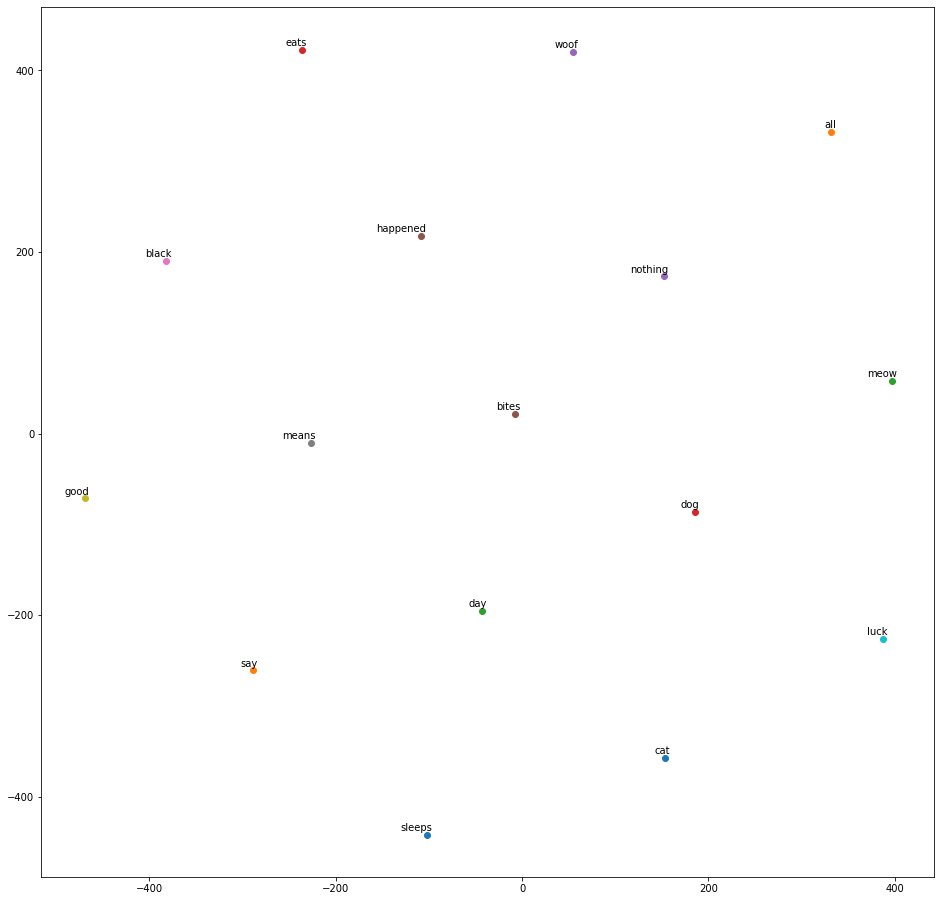

In [12]:
tsne_plot(model)

In [13]:
#$xtra
mystop
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()
 
sentences = MySentences('/some/directory') # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences)

NameError: name 'mystop' is not defined